In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.adapt import MLkNN
from sklearn.metrics import hamming_loss, accuracy_score
import string 

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

from nltk.tokenize import word_tokenize
from sklearn import preprocessing

In [2]:
path = '../Multilabel_text_classifcation/jigsaw-toxic-comment-classification-challenge/'
df = pd.read_csv(path+'train.csv')
df_test = pd.read_csv(path+'test.csv')
df_submission = pd.read_csv(path+'sample_submission.csv')

df_sample_without_replacement = df.sample(2000)
df_validation_labelled = df_sample_without_replacement.iloc[:1000]
df_train_labelled = df_sample_without_replacement.iloc[1000:]
df_test_sample = df_test.sample(4000)

In [3]:
df_validation_labelled.to_csv('validation_labelled_sample.csv', index=False)
df_train_labelled.to_csv('train_labelled_sample.csv', index=False)
df_test_sample.to_csv('df_test_sample.csv', index=False)

In [4]:
df_test_sample

,id,comment_text
76489,7f8a0f5d2a9adfc2,== fuck off == \n\n You fucking geeks never le...
19460,20a64c3fbb3712da,:Agreed - critics have called it one of The Be...
506,00d2aca8d65aa590,== ޗޮޮލ! == \n\n މަލދިވެސ ިސ ަ ޕރެތތޔ ގޮޮދ ިސލ...
137666,e61d5d9288bc395d,""" \n ::::::Call me dense too, because if we sp..."
32104,355e7adc20c78289,"==GA Sweeps invitation== \n Hello, I hope you ..."
...,...,...
90012,960c78ac2c18306d,== Lars Vilks and Estonian ancestry == \n\n Th...
78236,8281fa843e578ce6,"* For 74 minute CD-Rs, the capacity is 74*60*4..."
20953,2310fef3e7e0c788,""" \n\n * \n\n {{#if:In this edit """"They both ..."
106587,b1e15c241c25256a,== Re: April 14-16 mega outbreak == \n\n Not a...


# multiclass

In [5]:
def training_model(X_train,y_train,vectorizer): 
    pipeline = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1200)),
                         ('clf', RandomForestClassifier())])
    model = pipeline.fit(X_train, y_train) #only used in the trained data
    return model

def cleaning_data(part_df):
    words = stopwords.words("english")
    part_df['comment_text_cleaned']= part_df['comment_text'].apply(lambda x: word_tokenize(x))
    part_df['comment_text_cleaned']= part_df['comment_text_cleaned'].apply(lambda x: [i for i in x if i not in words])
    part_df['comment_text_cleaned']= part_df['comment_text_cleaned'].apply(lambda x: " ".join([i for i in x if i not in string.punctuation]))
    return part_df

def vectorized_data(part_df):
    vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
    #final_features = vectorizer.fit_transform(part_df['comment_text_cleaned']).toarray()
    return vectorizer

def clean_target(sample_df):
    sample_df['toxic_string'] = sample_df['toxic'].apply(lambda x: "".join(['toxic' for i in [x] if i == 1]))
    sample_df['severe_toxic_string'] = sample_df['severe_toxic'].apply(lambda x: "".join(['severe_toxic' for i in [x] if i == 1]))
    sample_df['obscene_string'] = sample_df['obscene'].apply(lambda x: "".join(['obscene' for i in [x] if i == 1]))
    sample_df['threat_string'] = sample_df['threat'].apply(lambda x: "".join(['threat' for i in [x] if i == 1]))
    sample_df['insult_string'] = sample_df['insult'].apply(lambda x: "".join(['insult' for i in [x] if i == 1]))
    sample_df['identity_hate_string'] = sample_df['identity_hate'].apply(lambda x: "".join(['identity_hate' for i in [x] if i == 1]))
    sample_df['target_string'] = sample_df.apply(lambda x: x['toxic_string'] + x['severe_toxic_string']+ x['obscene_string'] + x['threat_string'] + x['insult_string'] + x['identity_hate_string'], axis = 1)
    return sample_df[['comment_text_cleaned','target_string']]

In [6]:
'''def label_encoding(df_train):
    le = preprocessing.LabelEncoder()
    le.fit(df_train['target_string']) #prepares model
    return le'''

"def label_encoding(df_train):\n    le = preprocessing.LabelEncoder()\n    le.fit(df_train['target_string']) #prepares model\n    return le"

In [7]:
#repeats process until no new labels can be added
def define_x_y(cleaned):
    X_train = cleaned['comment_text_cleaned']
    y_train = cleaned['target']
    return (X_train, y_train)

def training_process(cleaned):
    vectorized = vectorized_data(cleaned)
    vectorizer = vectorized
    X_train, y_train = define_x_y(cleaned)
    return training_model(X_train,y_train,vectorizer)

def train_val_scores(x, y_val, trained_model): 
    y_val_pred=trained_model.predict(x) #transform depending on which type of function you are talking about
    return precision_score(y_val,y_val_pred,average = 'weighted'),recall_score(y_val,y_val_pred,average = 'weighted')

#difficulties mapping list_classes to y_prob
'''def pseudo_label_creation(trained_model, cleaned_unlabelled):
    X_unlabelled = cleaned_unlabelled['comment_text_cleaned']
    y_prob = trained_model.predict_proba(X_unlabelled)
    #need to change the "propagate toxic/not-toxic bits to make it multiclass"
    #for loop to create multiple classes  
    cleaned_unlabelled['propagate_toxic']=np.where(y_prob[:,1] > 0.85,1, -1)
    cleaned_unlabelled['propagate_not_toxic']=np.where(y_prob[:,0] > 0.85,0,-1)
    cleaned_unlabelled['new_label'] = cleaned_unlabelled.apply(lambda x: np.max([x['propagate_toxic'], x['propagate_not_toxic']]), axis = 1)
    pseudo_label_df = cleaned_unlabelled[cleaned_unlabelled['new_label'] > -1]
    remaining_unlabelled_df = cleaned_unlabelled[cleaned_unlabelled['new_label'] == -1]
    pseudo_label_df.rename(columns={'new_label':'toxic'}, inplace=True)
    return pseudo_label_df, remaining_unlabelled_df'''

'def pseudo_label_creation(trained_model, cleaned_unlabelled):\n    X_unlabelled = cleaned_unlabelled[\'comment_text_cleaned\']\n    y_prob = trained_model.predict_proba(X_unlabelled)\n    #need to change the "propagate toxic/not-toxic bits to make it multiclass"\n    #for loop to create multiple classes  \n    cleaned_unlabelled[\'propagate_toxic\']=np.where(y_prob[:,1] > 0.85,1, -1)\n    cleaned_unlabelled[\'propagate_not_toxic\']=np.where(y_prob[:,0] > 0.85,0,-1)\n    cleaned_unlabelled[\'new_label\'] = cleaned_unlabelled.apply(lambda x: np.max([x[\'propagate_toxic\'], x[\'propagate_not_toxic\']]), axis = 1)\n    pseudo_label_df = cleaned_unlabelled[cleaned_unlabelled[\'new_label\'] > -1]\n    remaining_unlabelled_df = cleaned_unlabelled[cleaned_unlabelled[\'new_label\'] == -1]\n    pseudo_label_df.rename(columns={\'new_label\':\'toxic\'}, inplace=True)\n    return pseudo_label_df, remaining_unlabelled_df'

In [8]:
# np.where for 1 class
# will have to do it for all the classes

In [9]:
import warnings
warnings.filterwarnings("ignore")

size_new_labels = 51
cleaned = cleaning_data(df_train_labelled)
cleaned_val = cleaning_data(df_validation_labelled)
cleaned_train = clean_target(cleaned)
cleaned_val = clean_target(cleaned_val)

# you have to clean also the comment_text in unlabelled data
cleaned_unlabelled = cleaning_data(df_test_sample)


In [10]:
#enumerate is to iterate the index and the value of the index in a list
#value = key, i is the number associated with the key
dict_labels = {value:i for i,value in enumerate(cleaned_train.drop_duplicates('target_string').target_string.tolist())}
dict_labels

{'': 0,
 'toxic': 1,
 'toxicobsceneinsult': 2,
 'toxicinsult': 3,
 'toxicidentity_hate': 4,
 'toxicobscene': 5,
 'toxicsevere_toxicobsceneinsult': 6,
 'toxicsevere_toxicobsceneinsultidentity_hate': 7,
 'toxicobscenethreatinsult': 8,
 'identity_hate': 9,
 'obsceneinsult': 10,
 'toxicobsceneinsultidentity_hate': 11,
 'toxicsevere_toxic': 12,
 'toxicobscenethreatinsultidentity_hate': 13,
 'obscene': 14,
 'toxicsevere_toxicobscene': 15,
 'toxicsevere_toxicthreat': 16,
 'toxicinsultidentity_hate': 17}

In [11]:
#increases size of labels not seen
#save number of last label
n_labels = len(dict_labels)
cleaned_val_list = cleaned_val.drop_duplicates('target_string').target_string.tolist()
for value in cleaned_val_list:
    if value not in dict_labels:
        dict_labels[value] = n_labels
        n_labels += 1

dict_labels
    

{'': 0,
 'toxic': 1,
 'toxicobsceneinsult': 2,
 'toxicinsult': 3,
 'toxicidentity_hate': 4,
 'toxicobscene': 5,
 'toxicsevere_toxicobsceneinsult': 6,
 'toxicsevere_toxicobsceneinsultidentity_hate': 7,
 'toxicobscenethreatinsult': 8,
 'identity_hate': 9,
 'obsceneinsult': 10,
 'toxicobsceneinsultidentity_hate': 11,
 'toxicsevere_toxic': 12,
 'toxicobscenethreatinsultidentity_hate': 13,
 'obscene': 14,
 'toxicsevere_toxicobscene': 15,
 'toxicsevere_toxicthreat': 16,
 'toxicinsultidentity_hate': 17,
 'toxicthreatidentity_hate': 18,
 'threat': 19,
 'toxicsevere_toxicobscenethreatinsult': 20,
 'insult': 21,
 'obsceneinsultidentity_hate': 22}

In [12]:
cleaned_train['target'] = cleaned_train['target_string'].map(dict_labels)
cleaned_val['target'] = cleaned_val['target_string'].map(dict_labels)

#REMOVED BECAUSE OF ISSUES WITH LABEL ENCODER#
#label encoding doesn't ignore things that are not in the test
le = label_encoding(cleaned_train.append(cleaned_val, ignore_index  = True))
cleaned_train['target'] = le.transform(cleaned_train['target_string'])
cleaned_val['target'] = le.transform(cleaned_val['target_string'])
#unlabelled part has no target: cleaned_unlabelled['target'] = le.transform(cleaned_unlabelled['target_string'])
vectorized = vectorized_data(cleaned_train)
X_val, y_val = define_x_y(cleaned_val)

In [13]:
list_classes = np.sort(cleaned_train['target'].unique())
list_classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int64)

In [14]:
cleaned_val['target'].unique()

array([ 0,  1,  2, 18, 11, 19,  5, 14,  6, 17,  3, 20,  8, 21, 22, 13,  7,
       10], dtype=int64)

In [16]:
trained_model = training_process(cleaned_train)
X_train,y_train = define_x_y(cleaned_train) 
X_val,y_val = define_x_y(cleaned_val) 
#print('train\nprecision, recall, roc_auc_score ')
p,r = train_val_scores(X_train,y_train, trained_model)
#print('val\nprecision, recall, roc_auc_score ')
p,r = train_val_scores(X_val, y_val, trained_model)

In [17]:
#create new pseudo labels
X_unlabelled = cleaned_unlabelled['comment_text_cleaned']
y_prob = trained_model.predict_proba(X_unlabelled)
#need to change the "propagate toxic/not-toxic bits to make it multiclass"
#also need a for loop to create multiple classes  
y_prob[0]

array([0.02541667, 0.        , 0.40291667, 0.        , 0.        ,
       0.28166667, 0.18      , 0.06      , 0.        , 0.        ,
       0.        , 0.03      , 0.01      , 0.        , 0.        ,
       0.01      , 0.        , 0.        ])

In [18]:
for multiclass in list_classes:
    cleaned_unlabelled['propagate_' + str(multiclass)]=np.where(y_prob[:,multiclass] > 0.65,multiclass, -1)

cleaned_unlabelled['new_label'] = cleaned_unlabelled.apply(lambda x: np.max([x['propagate_' + str(multiclass)] for multiclass in list_classes]), axis = 1)
pseudo_label_df = cleaned_unlabelled[cleaned_unlabelled['new_label'] > -1]
remaining_unlabelled_df = cleaned_unlabelled[cleaned_unlabelled['new_label'] == -1]
pseudo_label_df.rename(columns={'new_label': 'target'}, inplace=True)
pseudo_label_df.head(50)



,id,comment_text,comment_text_cleaned,propagate_0,propagate_1,propagate_2,propagate_3,propagate_4,propagate_5,propagate_6,...,propagate_9,propagate_10,propagate_11,propagate_12,propagate_13,propagate_14,propagate_15,propagate_16,propagate_17,target
19460,20a64c3fbb3712da,:Agreed - critics have called it one of The Be...,Agreed critics called one The Beatles best cov...,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
137666,e61d5d9288bc395d,""" \n ::::::Call me dense too, because if we sp...",`` :Call dense speak `` '' Baltic '' '' `` '' ...,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
32104,355e7adc20c78289,"==GA Sweeps invitation== \n Hello, I hope you ...",==GA Sweeps invitation== Hello I hope well I s...,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
9486,0fdd5aec08b5ceef,""" \n\n == Thenewgay.net interview == \n\n Can ...",`` == Thenewgay.net interview == Can someone a...,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
69536,73c12e04e24f6232,Deuce is fuckin out!!!!! u douches!!!!!!!!! ju...,Deuce fuckin u douches jus accept fact dumbass...,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
4123,070ebbfa213aa7c3,i think that this book is worth reading but ha...,think book worth reading hard understand hell ...,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
86487,904d22e295aea729,::I left a message at the Graphics Lab request...,:I left message Graphics Lab requesting help f...,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
5347,09022d9450696c18,::I prefer the present lead image. The FP look...,:I prefer present lead image The FP looks like...,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
120808,c9b793dcc9dcb16d,""" \n :For now id leave it. Just keep the link...",`` For id leave Just keep links THat preferenc...,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
76181,7f018a2431924650,"Looks like Assad is going no where, Russia mad...",Looks like Assad going Russia made well known ...,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0


In [19]:

def pseudo_label_creation(list_classes, trained_model, cleaned_unlabelled):
    X_unlabelled = cleaned_unlabelled['comment_text_cleaned']
    y_prob = trained_model.predict_proba(X_unlabelled)
    #need to change the "propagate toxic/not-toxic bits to make it multiclass"
    #for loop to create multiple classes  
    for multiclass in list_classes:
        cleaned_unlabelled['propagate_' + str(multiclass)]=np.where(y_prob[:,multiclass] > 0.65,multiclass, -1)
    cleaned_unlabelled['new_label'] = cleaned_unlabelled.apply(lambda x: np.max([x['propagate_' + str(multiclass)] for multiclass in list_classes]), axis = 1)
    pseudo_label_df = cleaned_unlabelled[cleaned_unlabelled['new_label'] > -1]
    remaining_unlabelled_df = cleaned_unlabelled[cleaned_unlabelled['new_label'] == -1]
    pseudo_label_df.rename(columns={'new_label': 'target'}, inplace=True)
    return pseudo_label_df, remaining_unlabelled_df

In [23]:
val_precision = []
val_recall = []
val_roc_auc_score = []
min_new_labels = 50
size_training = []

while size_new_labels > min_new_labels:
    print(len(cleaned))
    trained_model = training_process(cleaned_train)
    X_train,y_train = define_x_y(cleaned_train) 
    X_val,y_val = define_x_y(cleaned_val) 
    #print('train\nprecision, recall, roc_auc_score ')
    p,r = train_val_scores(X_train,y_train, trained_model)
    #print('val\nprecision, recall, roc_auc_score ')
    p,r = train_val_scores(X_val, y_val, trained_model)
    val_precision.append(p)
    val_recall.append(r)    
    pseudo_label_df, cleaned_unlabelled = pseudo_label_creation(list_classes,trained_model,cleaned_unlabelled)
    #print('new_pseudo_labels')
    size_new_labels = len(pseudo_label_df)
    print(size_new_labels)
    size_training.append(len(cleaned))
    
    if size_new_labels > min_new_labels:
        cleaned = cleaned.append(pseudo_label_df[['comment_text_cleaned', 'target']], ignore_index = True)

1000
3045
4045
117
4162
12


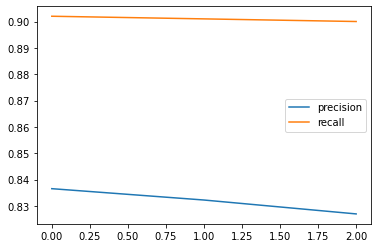

In [24]:
plt.plot(val_precision, label = 'precision')
plt.plot(val_recall, label = 'recall')
plt.legend()

Text(0, 0.5, 'Precision')

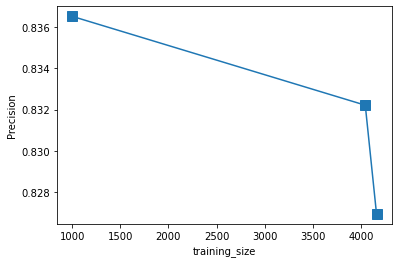

In [25]:
plt.plot(size_training, val_precision, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Precision')

Text(0, 0.5, 'Recall')

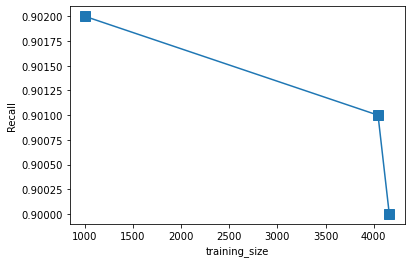

In [26]:
plt.plot(size_training, val_recall, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Recall')